# Estimate Drawdown Caused by Groundwater Pumping
## The objective is to investigate how well the heads measured in an observation well can be simulated using rainfall and reference evaporation.

### importing libraries
**Pastas is a new and open source Python package for the analysis of hydrogeological time series**

In [1]:
import pastas as ps
import pandas as pd
import matplotlib.pyplot as plt
import os

ps.set_log_level("ERROR")
ps.show_versions()

Python version: 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.18.5
Scipy version: 1.5.0
Pandas version: 1.0.5
Pastas version: 0.16.0
Matplotlib version: 3.2.2


**Measured Heads dataset :obtained from Dino loket**

In [3]:
gwdata=pd.read_csv('head_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
print("The data type of the oseries is:", type(gwdata))

The data type of the oseries is: <class 'pandas.core.series.Series'>


In [4]:
gwdata.head()

date
1985-11-14    27.61
1985-11-28    27.73
1985-12-14    27.91
1985-12-28    28.13
1986-01-13    28.32
Name: head, dtype: float64

Text(0.5, 0, 'Time [years]')

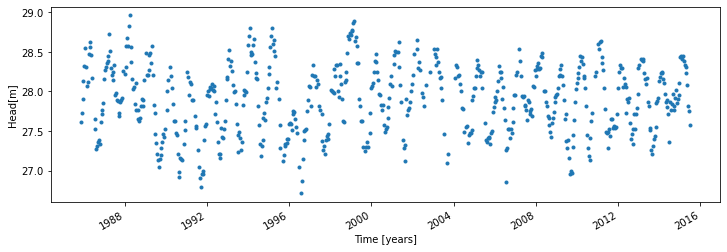

In [5]:
gwdata.plot(style='.', figsize=(12,4))
plt.ylabel('Head[m]')
plt.xlabel('Time [years]')

### The independent time series
The head variation is believed to be caused by two stresses: <br>
**rainfall:Taken from rainfall station Heibloem in The Netherlands.** <br>
**evaporation:taken from weather station Maastricht in The Netherlands**

In [6]:
#Importing observed rain series
rain=pd.read_csv('rain_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
print("the data type of the rain series is:", type(rain))


the data type of the rain series is: <class 'pandas.core.series.Series'>


In [7]:
#Importing observed evaporation series
evap=pd.read_csv('evap_nb1.csv', parse_dates=['date'] , index_col='date', squeeze=True)

print('The data type of the evap series is', type(evap))


The data type of the evap series is <class 'pandas.core.series.Series'>


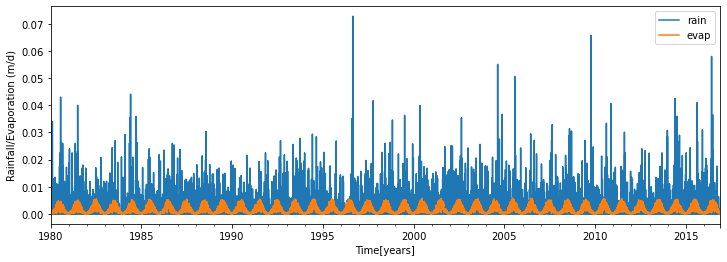

In [8]:
#plotting the time series of rain and evaporation
plt.figure(figsize=(12,4))
rain.plot(label='rain')
evap.plot(label='evap')
plt.xlabel('Time[years]')
plt.ylabel('Rainfall/Evaporation (m/d)')
plt.legend(loc='best')

### Recharge:
* the recharge is approximated as the measured rainfall minus the measured potential evaporation.

Text(0, 0.5, 'Recharge(m/d)')

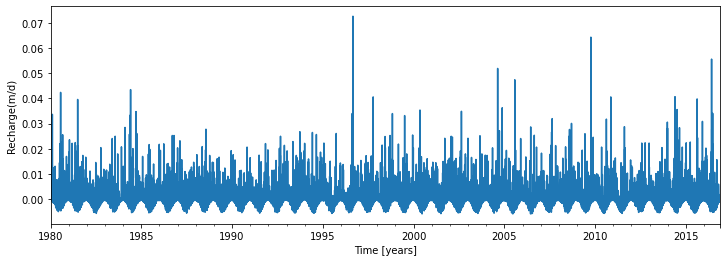

In [9]:
#calculating recharge of ground water
recharge=rain-evap
plt.figure(figsize=(12,4))
recharge.plot()
plt.xlabel('Time [years]')
plt.ylabel('Recharge(m/d)')

### Creating a Pastas model and adding stresses
**The impulse response function used in this model the scaled Gamma distribution**

In [10]:
#Createing a model object by passing it to the observed series
ml=ps.Model(gwdata, name="GWL")

#add the recharge data as explanatory variable
sm=ps.StressModel(recharge,ps.Gamma, name='recharge', settings='evap')
ml.add_stressmodel(sm)


### Estimating model parameters
**A is the scaling factor** <br> 
**a and n are shape parameters** <br>
**parameter optimisation method used is least squared errors**

In [11]:
ml.solve()

Fit report GWL                   Fit Statistics
nfev     23                     EVP          91.29
nobs     644                    R2            0.91
noise    True                   RMSE          0.13
tmin     1985-11-14 00:00:00    AIC           5.32
tmax     2015-06-28 00:00:00    BIC          27.66
freq     D                      Obj           2.09
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           Interpolated    No

Parameters (5 were optimized)
                optimal   stderr     initial  vary
recharge_A   753.595970   ±5.17%  215.674528  True
recharge_n     1.054411   ±1.50%    1.000000  True
recharge_a   135.887879   ±7.05%   10.000000  True
constant_d    27.552231   ±0.08%   27.900078  True
noise_alpha   61.768170  ±12.66%   15.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.86
           constant_d -0.79
recharge_n recharge_a -0.71
recharge_a constant_d -0.67


In [15]:
ml.stats.summary()

,Value
Statistic,
rmse,0.125151
rmsn,0.081644
sse,8.109972
mae,0.099808
nse,0.920233
evp,92.023503
rsq,0.920176
bic,27.063687
aic,5.813811


### Visualizing model results

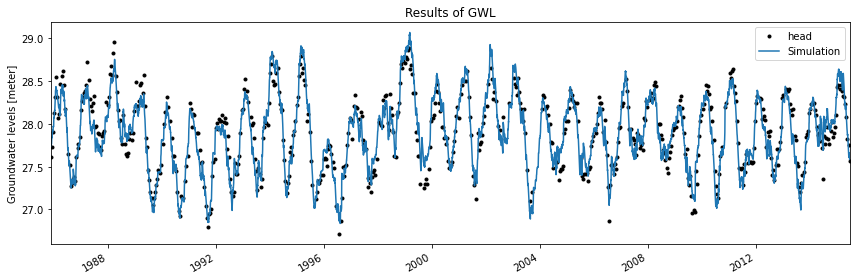

In [12]:
ml.plot(figsize=(12,4))

**H0 : The residuals are independent, homoscedastic, or normally distributed**<br>

**HA: The residuals are not independent, homoscedastic, or normally distributed**

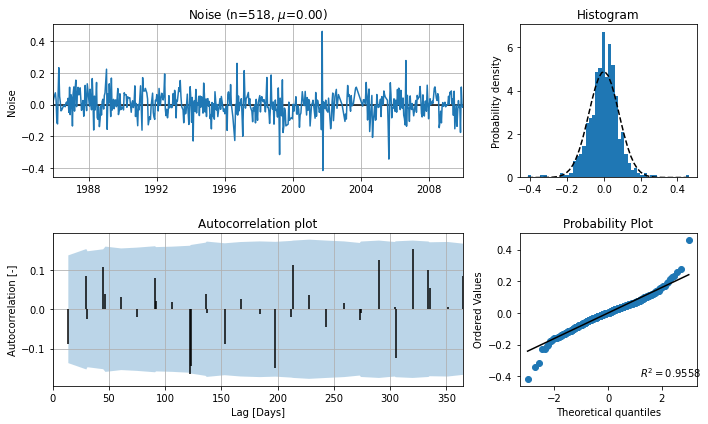

In [16]:
alpha = 0.05
ml.plots.diagnostics()

In [17]:
ml.stats.diagnostics(alpha=0.05)

,Checks,Statistic,P-value,Reject H0
Shapiroo,Normality,0.96,0.00,True
D'Agostino,Normality,53.36,0.00,True
Runs test,Autocorr.,-0.44,0.66,False
Stoffer-Toloi,Autocorr.,10.94,0.69,False


**Stoffer-Tolo:This test checks whether the autocorrelations of a time series are significantly different from zero.**<br>
**As the p-value is greater than alpha level so no Autocorrelation in residuals**